Hello everyone! This is my solution for this month tabular playground. I learned a lot during my work on this dataset and from notebooks of other participants. Those two kernels were most helpfull and informative. Don't forget to check them too :D <br>
[TPS-May Categorical EDA](https://www.kaggle.com/subinium/tps-may-categorical-eda) <br>
[TPS May: RAPIDS](https://www.kaggle.com/ruchi798/tps-may-rapids)


In [1]:
import pandas as pd
import umap.umap_ as umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss

# ML
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
data_train = pd.read_csv('data/train.csv').drop('id', axis=1)
data_test = pd.read_csv('data/test.csv').drop('id', axis=1)

In [3]:
all_data = pd.concat([data_train, data_test], axis=0)

In [4]:
data_train

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0              0          0          1          0          1          0   
1              0          0          0          0          2          1   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
99995          0          0          0          1          0          0   
99996          0          0          0          0          0          0   
99997          0          0          0          0          0          1   
99998          0          0          0          0          1          0   
99999          0          0          0          0          0          0   

       feature_6  feature_7  feature_8  feature_9  ...  feature_41  \
0              0          0          0          0  ...           0   
1              0          0          0          0  ...           0   
2              0          0          0          2  ...           0   
3              0          3          0          0  ...           0   
4              0          0          0          0  ...           0   
...          ...        ...        ...        ...  ...         ...   
99995          0          2          0          0  ...           0   
99996          0          1          2          0  ...           0   
99997          0          0          0          4  ...           0   
99998          0          0          0          5  ...           0   
99999          0          0          0          3  ...           0   

       feature_42  feature_43  feature_44  feature_45  feature_46  feature_47  \
0               0          21           0           0           0           0   
1               0           0           0           0           0           0   
2               1           0           0           0           0          13   
3               0           0           0           0           0           0   
4               0           0           0           0           0           0   
...           ...         ...         ...         ...         ...         ...   
99995           0           6           0           0           3           0   
99996           2           0           0           0          10           0   
99997           0           0           0           1           0           0   
99998           0           0           0           0           1           0   
99999           5           0           0           0           1           0   

       feature_48  feature_49   target  
0               0           0  Class_2  
1               0           0  Class_1  
2               2           0  Class_1  
3               1           0  Class_4  
4               1           0  Class_2  
...           ...         ...      ...  
99995           0           0  Class_1  
99996           0           0  Class_2  
99997           2           0  Class_3  
99998           4           0  Class_2  
99999           0           8  Class_3  

[100000 rows x 51 columns]

<h2>EDA</h2>

<h3>Missing values</h3>

In [5]:
all_data.isnull().sum()

feature_0         0
feature_1         0
feature_2         0
feature_3         0
feature_4         0
feature_5         0
feature_6         0
feature_7         0
feature_8         0
feature_9         0
feature_10        0
feature_11        0
feature_12        0
feature_13        0
feature_14        0
feature_15        0
feature_16        0
feature_17        0
feature_18        0
feature_19        0
feature_20        0
feature_21        0
feature_22        0
feature_23        0
feature_24        0
feature_25        0
feature_26        0
feature_27        0
feature_28        0
feature_29        0
feature_30        0
feature_31        0
feature_32        0
feature_33        0
feature_34        0
feature_35        0
feature_36        0
feature_37        0
feature_38        0
feature_39        0
feature_40        0
feature_41        0
feature_42        0
feature_43        0
feature_44        0
feature_45        0
feature_46        0
feature_47        0
feature_48        0
feature_49        0


As we can see there aren't any missing values in this dataset

<h3>Feature Description</h3>

In [6]:
data_test.describe().T.style.bar(subset=['mean', 'std'], color='#d65f5f')

In [7]:
data_train.describe().T.style.bar(subset=['mean', 'std'], color='#d65f5f')

<h3>Target Distribution</h3>

In [8]:
fig = go.Figure()

to_plot = data_train.value_counts('target')

fig.add_trace(go.Pie(
    labels = to_plot.index,
    values = to_plot.values,
    textinfo='label+percent'
))

fig.update_layout(
    template='plotly_dark',
    title_text = 'Target Distribution'
)

Unfortunately we have huge disbalance in our target variable. We will do something with this if it's gona be a problem later

<h3>Features Distribution</h3>

In [9]:
fig = make_subplots(
    rows=10,
    cols=5,
    subplot_titles=data_train.columns,
)

# Add traces
columns = data_train.drop('target', axis=1).columns.tolist()

for row in range(10):
    for col in range(5):
        column = columns.pop(0)
        to_plot = data_train[column].value_counts()

        fig.add_trace(go.Scatter(
            x = to_plot.index,
            y = to_plot.values,
            name = column,
            mode='lines'
        ), col=col+1, row=row+1)

        fig.update_yaxes(title='y', visible=False, showticklabels=False)

        if(col+1 == 5):
            break

fig.update_layout(
    height=1000,
    width=700,
    showlegend=False,
    template='plotly_dark',
)
fig.update_annotations(font_size=12)

There is a lot of zero values in every feature. I'm curious how much of dataset is filled with them.

In [10]:
to_plot = data_train.drop('target', axis=1).isin([0]).sum(axis=0)
percent = np.array(to_plot)/100000 * 100

fig = go.Figure()

fig.add_trace(go.Bar(
    x = to_plot.values,
    y = to_plot.index,
    orientation='h',
    text = np.round(percent, 2),
    textposition='outside',
    marker={
        'color': to_plot.values,
        'colorscale': 'Purples',

    }
))

fig.update_layout(
    height=1000,
    width=700,
    template='plotly_dark',
    title_text='Percent of zeros in every column'
)

<h3>Correlation</h3>

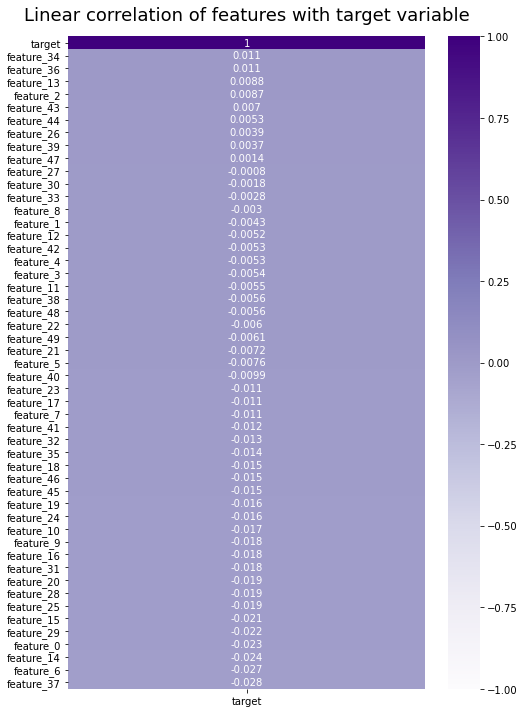

In [11]:
data_train_target_num = data_train.replace({'target': {'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4}})

plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(data_train_target_num.corr()[['target']].sort_values(by='target', ascending=False),
                     vmin=-1, vmax=1, annot=True, cmap='Purples')

heatmap.set_title('Linear correlation of features with target variable', fontdict={'fontsize': 18}, pad=16);

<h3>Conclusion</h3>

After some visualization and discussion couple of things come up to the light
<ul>
    <li>There aren't any missing values</li>
    <li>Mean and standard deviation is fairly the same for train and test datasets</li>
    <li>Target variable is unbalanced which can be a problem</li>
    <li>Features are left skewed and nearly 60% of every feature is filled with zeros</li>
    <li>Features show weak linear correlation with target variable</li>
</ul>

<h2>Dimensionality Reduction</h2>
There is 50 features in our dataset. It's good opportunity to perform dimensionality reduction but first we gona check if it's necessary to do so.

<h3>Dimensionality reduction using PCA </h3>

In [12]:
pca = PCA().fit(data_train.drop('target', axis=1))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = list(range(50)),
    y = np.cumsum(pca.explained_variance_ratio_)
))

fig.update_layout(
    template = 'plotly_dark',
    title_text = 'PCA Performence',
    xaxis_title = 'Number of components',
    yaxis_title = 'Cumulative explained variance'
)

As we can see from scatter plot above variance decreasing quite fast. By the time PCA reduce number of features to the 30 we had lost almost 10% of the variance. It's definitely not worth it to reduce dimensionality of this dataset in order to create prediction model but still we can use dimensionality reduction to visualize our dataset. 

In [13]:
pca_vis = PCA(3)
projected = pca_vis.fit_transform(data_train.drop('target', axis=1))

In [14]:
df_vis = pd.DataFrame(projected, columns=['x', 'y', 'z'])
df_vis['target'] = data_train['target']

In [15]:
fig = px.scatter_3d(df_vis, x='x', y='y', z='z', color='target')

# tight layout
fig.update_layout(
    template='plotly_dark'
)

PCA doesn't work very well but it's doesn't mean that visualization is impossible we gonna use other method to do so

<h3> Dimensionality reduction using umap </h3>

In [16]:
sample_data_train = data_train.sample(1000, random_state=42)
scaled_sample_train = pd.DataFrame(StandardScaler().fit_transform(sample_data_train.drop('target', axis=1)))
scaled_sample_target = sample_data_train.replace({'target': {'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4}})['target'].reset_index(drop=True)

In [17]:
reducer_2d = umap.UMAP(random_state=1)
embedding_2d = reducer_2d.fit_transform(scaled_sample_train, scaled_sample_target)

In [18]:
df_test_2d = pd.DataFrame(embedding_2d, columns=['x', 'y'])
df_test_2d['target'] = scaled_sample_target

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = df_test_2d[df_test_2d['target'] == 1]['x'],
    y = df_test_2d[df_test_2d['target'] == 1]['y'],
    mode='markers',
    name='Class_1'
))

fig.add_trace(go.Scatter(
    x = df_test_2d[df_test_2d['target'] == 2]['x'],
    y = df_test_2d[df_test_2d['target'] == 2]['y'],
    mode='markers',
    name='Class_2'
))

fig.add_trace(go.Scatter(
    x = df_test_2d[df_test_2d['target'] == 3]['x'],
    y = df_test_2d[df_test_2d['target'] == 3]['y'],
    mode='markers',
    name='Class_3'
))

fig.add_trace(go.Scatter(
    x = df_test_2d[df_test_2d['target'] == 4]['x'],
    y = df_test_2d[df_test_2d['target'] == 4]['y'],
    mode='markers',
    name='Class_4'
))

fig.update_layout(
    title_text = '2d dataset visualization using UMAP',
    template = 'plotly_dark'
)

In [20]:
reducer_3d = umap.UMAP(random_state=42, n_components=3)
embedding_3d = reducer_3d.fit_transform(scaled_sample_train, scaled_sample_target)

In [21]:
df_test_3d = pd.DataFrame(embedding_3d, columns=['x', 'y', 'z'])
df_test_3d['target'] = scaled_sample_target

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x = df_test_3d[df_test_3d['target'] == 1]['x'],
    y = df_test_3d[df_test_3d['target'] == 1]['y'],
    z = df_test_3d[df_test_3d['target'] == 1]['z'],
    mode = 'markers',
    name = 'Class_1',
    marker = dict(
        size=4
    )
))

fig.add_trace(go.Scatter3d(
    x = df_test_3d[df_test_3d['target'] == 2]['x'],
    y = df_test_3d[df_test_3d['target'] == 2]['y'],
    z = df_test_3d[df_test_3d['target'] == 2]['z'],
    mode = 'markers',
    name = 'Class_2',
    marker = dict(
        size=4
    )
))

fig.add_trace(go.Scatter3d(
    x = df_test_3d[df_test_3d['target'] == 3]['x'],
    y = df_test_3d[df_test_3d['target'] == 3]['y'],
    z = df_test_3d[df_test_3d['target'] == 3]['z'],
    mode = 'markers',
    name = 'Class_3',
    marker = dict(
        size=4
    )
))

fig.add_trace(go.Scatter3d(
    x = df_test_3d[df_test_3d['target'] == 4]['x'],
    y = df_test_3d[df_test_3d['target'] == 4]['y'],
    z = df_test_3d[df_test_3d['target'] == 4]['z'],
    mode = 'markers',
    name = 'Class_4',
    marker = dict(
        size=4
    )
))

fig.update_layout(
    title_text = '3d dataset visualization using UMAP',
    template = 'plotly_dark'
)

Now our visualization looks much better we can clearly see clouds of different classes. 

<h2> Prediction model creation </h2>

In [23]:
data_train_num = data_train

X = data_train_num.drop('target', axis=1)
y = data_train_num['target']

<h3> Scalling </h3>

In [24]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

<h3> XGBoost </h3>

In [25]:
log_pred = np.zeros((len(X), 4))
test_pred = np.zeros((len(data_test), 4))

In [26]:
xgb_model = XGBClassifier()

In [ ]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (train_index, val_index) in enumerate(skf.split(X, y)):
    print('Fold: ', fold_)
    model = xgb_model.fit(
        X.iloc[train_index],
        y.iloc[train_index],
        eval_set = [(X.iloc[train_index], y.iloc[train_index]), (X.iloc[val_index], y.iloc[val_index])],
        eval_metric = 'mlogloss',
        early_stopping_rounds = 50, 
        verbose = 0
    )

    temp_pred = model.predict_proba(X.iloc[val_index])
    log_pred[val_index] = temp_pred

    print(f'Log Loss: {log_loss(y.iloc[val_index], temp_pred)}')

    temp_test = model.predict_proba(data_test)
    test_pred += temp_test

test_pred1 = test_pred/5

print(f'Overall Log Loss: {log_loss(y, log_pred)}')

<h3> Light Gradient Boost </h3>

In [28]:
log_pred = np.zeros((len(X), 4))
test_pred = np.zeros((len(data_test), 4))

In [29]:
lg_model = LGBMClassifier()

In [30]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (train_index, val_index) in enumerate(skf.split(X, y)):
    print('Fold: ', fold_)
    model = lg_model.fit(
        X.iloc[train_index],
        y.iloc[train_index],
        eval_set = [(X.iloc[train_index], y.iloc[train_index]), (X.iloc[val_index], y.iloc[val_index])],
        eval_metric = 'multi_logloss',
        early_stopping_rounds = 50,
        verbose = 0
    )

    temp_pred = model.predict_proba(X.iloc[val_index])
    log_pred[val_index] = temp_pred

    print(f'Log Loss: {log_loss(y.iloc[val_index], temp_pred)}')

    temp_test = model.predict_proba(data_test)
    test_pred += temp_test

test_pred2 = test_pred/5

print(f'Overall Log Loss: {log_loss(y, log_pred)}')

Fold:  0
Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_logloss: 1.09624	valid_1's multi_logloss: 1.10727
[20]	valid_0's multi_logloss: 1.08202	valid_1's multi_logloss: 1.10256
[30]	valid_0's multi_logloss: 1.07038	valid_1's multi_logloss: 1.09965
[40]	valid_0's multi_logloss: 1.06068	valid_1's multi_logloss: 1.09859
[50]	valid_0's multi_logloss: 1.05188	valid_1's multi_logloss: 1.09813
[60]	valid_0's multi_logloss: 1.0442	valid_1's multi_logloss: 1.09777
[70]	valid_0's multi_logloss: 1.03708	valid_1's multi_logloss: 1.09769
[80]	valid_0's multi_logloss: 1.03058	valid_1's multi_logloss: 1.09793
[90]	valid_0's multi_logloss: 1.02422	valid_1's multi_logloss: 1.0981
[100]	valid_0's multi_logloss: 1.01783	valid_1's multi_logloss: 1.0983
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.01783	valid_1's multi_logloss: 1.0983
Log Loss: 1.0983001986518488
Fold:  1
Training until validation scores don't improve for 50 rounds
[10]

<h3> Catboost </h3>

In [31]:
log_pred = np.zeros((len(X), 4))
test_pred = np.zeros((len(data_test), 4))

In [32]:
cat_model = CatBoostClassifier()

In [ ]:
%%time

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold_, (train_index, val_index) in enumerate(skf.split(X, y)):
    print('Fold: ', fold_)
    model = cat_model.fit(
        X.iloc[train_index],
        y.iloc[train_index],
        eval_set = [(X.iloc[train_index], y.iloc[train_index]), (X.iloc[val_index], y.iloc[val_index])],
        early_stopping_rounds = 50,
        verbose=0

    )

    temp_pred = model.predict_proba(X.iloc[val_index])
    log_pred[val_index] = temp_pred

    print(f'Log Loss: {log_loss(y.iloc[val_index], temp_pred)}')

    temp_test = model.predict_proba(data_test)
    test_pred += temp_test

test_pred3 = test_pred/10

print(f'Overall Log Loss: {log_loss(y, log_pred)}')

In [34]:
df_pred1 = pd.DataFrame(test_pred1)
df_pred2 = pd.DataFrame(test_pred2)
df_pred3 = pd.DataFrame(test_pred3)

In [35]:
data_test1 = pd.read_csv('data/sample_submission.csv').drop(['Class_1', 'Class_2', 'Class_3', 'Class_4'], axis=1)

data_test1['Class_1'] = df_pred1[0]
data_test1['Class_2'] = df_pred1[1]
data_test1['Class_3'] = df_pred1[2]
data_test1['Class_4'] = df_pred1[3]

In [36]:
data_test2 = pd.read_csv('data/sample_submission.csv').drop(['Class_1', 'Class_2', 'Class_3', 'Class_4'], axis=1)

data_test2['Class_1'] = df_pred2[0]
data_test2['Class_2'] = df_pred2[1]
data_test2['Class_3'] = df_pred2[2]
data_test2['Class_4'] = df_pred2[3]

In [37]:
data_test3 = pd.read_csv('data/sample_submission.csv').drop(['Class_1', 'Class_2', 'Class_3', 'Class_4'], axis=1)

data_test3['Class_1'] = df_pred3[0]
data_test3['Class_2'] = df_pred3[1]
data_test3['Class_3'] = df_pred3[2]
data_test3['Class_4'] = df_pred3[3]

In [38]:
df_pred1

0         1         2         3
0      0.087216  0.616459  0.176588  0.119737
1      0.076323  0.603766  0.208488  0.111423
2      0.092662  0.608285  0.194935  0.104118
3      0.087497  0.558189  0.235254  0.119060
4      0.076545  0.602993  0.214333  0.106129
...         ...       ...       ...       ...
49995  0.083641  0.685351  0.156975  0.074032
49996  0.082029  0.629210  0.156785  0.131975
49997  0.090865  0.523157  0.217207  0.168770
49998  0.091018  0.568040  0.193122  0.147820
49999  0.088314  0.563265  0.203839  0.144582

[50000 rows x 4 columns]

In [39]:
df_pred2

0         1         2         3
0      0.080621  0.584924  0.208605  0.125850
1      0.076971  0.669415  0.162039  0.091574
2      0.079288  0.648513  0.182172  0.090027
3      0.082253  0.544657  0.265035  0.108055
4      0.074468  0.618829  0.207551  0.099152
...         ...       ...       ...       ...
49995  0.108579  0.662368  0.157063  0.071990
49996  0.071042  0.667558  0.145404  0.115995
49997  0.082217  0.529768  0.210513  0.177502
49998  0.086599  0.601654  0.162302  0.149444
49999  0.096121  0.575753  0.202822  0.125304

[50000 rows x 4 columns]

In [40]:
df_pred3

0         1         2         3
0      0.092975  0.615122  0.169662  0.122241
1      0.085693  0.681441  0.148447  0.084420
2      0.086204  0.622103  0.184109  0.107584
3      0.084022  0.531593  0.282916  0.101468
4      0.072276  0.610124  0.196527  0.121074
...         ...       ...       ...       ...
49995  0.086505  0.723997  0.127859  0.061639
49996  0.083712  0.638884  0.138881  0.138523
49997  0.085968  0.523624  0.221560  0.168847
49998  0.077516  0.590777  0.166377  0.165331
49999  0.091262  0.576456  0.190814  0.141469

[50000 rows x 4 columns]

In [41]:
data_test3.to_csv('submission.csv', index=False)